In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.datasets import mnist
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm_notebook

The data is loaded.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize the input data to inverval [0, 1]
x_train = x_train.astype('float32') / 255
x_test  = x_test.astype('float32') / 255
# Flatten each image into a vecto'r
x_train = x_train.reshape(len(x_train), 784)
x_test  = x_test.reshape(len(x_test), 784)

In [3]:
def display10(imgs):
    n = 10  # How many digits we will display
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Some hand-written digits from the dataset is shown.

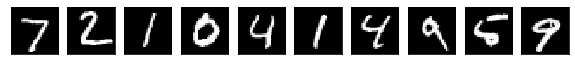

In [4]:
display10(x_test)

**First Case**: The number '4' is considered the normal case.

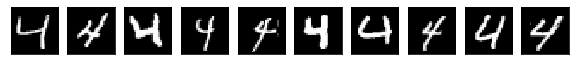

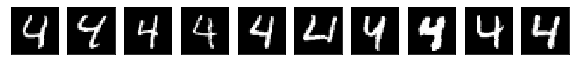

In [5]:
normal_train = x_train[np.where(y_train == 4)]
normal_test  = x_test[np.where(y_test == 4)]

display10(normal_train)
display10(normal_test)

A simple autoencoder structure is defined.

In [3]:
#Sigmoid and ReLU are appropriate activation functions when having nonnegative data.
model = keras.Sequential([
    layers.Input( shape=(784) ),
    # try 10 and 32
    # 10 because: Rumelheadt proposed to use log2(N), Log2(784) approx 10.
    layers.Dense(32, activation='relu' ),
    layers.Dense(784, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy')

In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=2)
]

model.fit(normal_train, normal_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks)

Epoch 1/50
23/23 [==============================] - 0s 13ms/step - loss: 0.5869 - val_loss: 0.4431
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 0.2894 - val_loss: 0.3569
Epoch 3/50
23/23 [==============================] - 0s 9ms/step - loss: 0.2312 - val_loss: 0.3299
Epoch 4/50
23/23 [==============================] - 0s 9ms/step - loss: 0.2174 - val_loss: 0.3141
Epoch 5/50
23/23 [==============================] - 0s 9ms/step - loss: 0.2045 - val_loss: 0.3037
Epoch 6/50
23/23 [==============================] - 0s 9ms/step - loss: 0.1921 - val_loss: 0.2960
Epoch 7/50
23/23 [==============================] - 0s 9ms/step - loss: 0.1816 - val_loss: 0.2908
Epoch 8/50
23/23 [==============================] - 0s 9ms/step - loss: 0.1728 - val_loss: 0.2853
Epoch 9/50
23/23 [==============================] - 0s 8ms/step - loss: 0.1652 - val_loss: 0.2798
Epoch 10/50
23/23 [==============================] - 0s 8ms/step - loss: 0.1586 - val_loss: 0.2756
Epoch 11/50
23/23 

From the below images it seems that the hypothesis is true and the reconstruction error can be utilized as an outlier score.

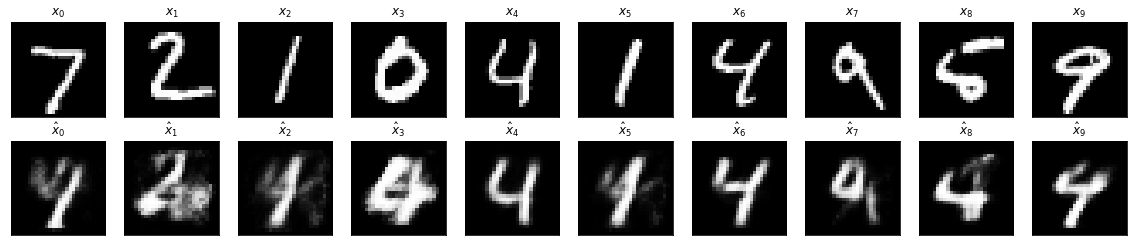

In [8]:
reconstructions = model.predict(x_test)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('$x_'+str(i)+'$')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('$\hat{x}_'+str(i)+'$')
plt.show()

## Creating the evaluation dataset

In [3]:
def create_dataset(y_test, normal=4):
    num_normals  = int(np.sum( y_test == normal ))
    num_outliers = int(np.ceil( num_normals * 0.10 ))
    # Get non-normal elements in test dataset
    sub_arr = x_test[ y_test != normal ]
    # Generate random non-normal indices
    idx = np.random.randint(low=0, high=len(sub_arr), size=num_outliers)
    # Create contaminated test data
    x_contaminated = np.zeros((num_normals + num_outliers, 784))
    x_contaminated[num_outliers:,:] = x_test[y_test == normal]
    x_contaminated[:num_outliers,:] = sub_arr[idx]
    # Create contaminated labels
    y_contaminated = np.zeros((num_normals + num_outliers))
    y_contaminated[num_outliers:] = normal
    y_contaminated[:num_outliers] = y_test[ y_test != normal ][idx]
    # Create binary anomaly labels,   normal = 0,   outlier = 1
    binary_labels = np.copy( y_contaminated )
    binary_labels[y_contaminated == normal] = 0
    binary_labels[y_contaminated != normal] = 1
    
    return (x_contaminated, y_contaminated, binary_labels)

def create_model():
    #Sigmoid and ReLU are appropriate activation functions when having nonnegative data.
    model = keras.Sequential([
        layers.Input( shape=(784) ),
        # try 10 and 32
        # 10 because: Rumelheadt proposed to use log2(N), Log2(784) approx 10.
        layers.Dense(32, activation='relu' ),
        layers.Dense(784, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

def fit_model(model, x_train, y_train, x_test, y_test, normal=4, verbose=0):
    callbacks = [
        keras.callbacks.EarlyStopping(patience=2)
    ]
    train = x_train[y_train==normal]
    test  = x_test[y_test==normal]
    history = model.fit(train, train,
                    epochs=50,
                    batch_size=256,
                    verbose=verbose,
                    shuffle=True,
                    validation_data=(test, test),
                    callbacks=callbacks)
    return model

In [4]:
evals = np.zeros((10, 30))
for i in range(10):
    # Evaluate for all numbers
    for j in tqdm_notebook(range(30)):
        # Evaluate each method 30 times
        model = create_model()
        model = fit_model(model, x_train, y_train, x_test, y_test, normal=i)

        x, y, labels = create_dataset(y_test, normal=i)
        xhat = model.predict(x)
        err  = np.sum(np.abs(x-xhat), axis=1)
        # Max-Min normalize the error
        err /= np.max(err)
        # Compute AUC
        AUC = roc_auc_score(labels, err)
        evals[i,j] = AUC

print(np.mean(evals, axis=1))
print(np.std(evals, axis=1))

KeyboardInterrupt: 

In [17]:
print(np.mean(evals, axis=1)*100)
print(np.std(evals, axis=1)*100)

[98.93662363 99.91235799 90.20429587 94.37494338 95.83061779 94.6356087
 98.64061413 97.09929662 86.35914736 96.67651269]
[0.31434816 0.03885487 1.5627968  1.15765485 1.78066949 1.23174309
 0.4360406  0.77941863 3.36474175 1.17835281]


## Misc

In [11]:
num_normals  = int(np.sum( y_test == 4 ))
num_outliers = int(np.ceil( num_normals * 0.05 ))

In [12]:
sub_arr = x_test[ y_test != 4 ]
idx = np.random.randint(low=0, high=len(sub_arr), size=num_outliers)

x_contaminated = np.zeros((num_normals + num_outliers, 784))
x_contaminated[num_outliers:,:] = x_test[y_test == 4]
x_contaminated[:num_outliers,:] = sub_arr[idx]

y_contaminated = np.zeros((num_normals + num_outliers))
y_contaminated[num_outliers:] = 4
y_contaminated[:num_outliers] = y_test[ y_test != 4 ][idx]

In [13]:
xhat = model.predict(x_contaminated)

err  = np.abs(x_contaminated - xhat)
err  = np.sum(err, axis=1)

In [14]:
y_outliers = y_contaminated[np.argsort(err)[::-1]][:50]
print(y_outliers)

[0. 4. 0. 6. 0. 5. 2. 4. 4. 4. 4. 5. 4. 4. 4. 4. 0. 4. 4. 4. 8. 8. 4. 4.
 4. 2. 4. 4. 4. 4. 4. 2. 4. 4. 4. 6. 1. 4. 4. 4. 5. 4. 4. 4. 2. 1. 4. 4.
 8. 4.]


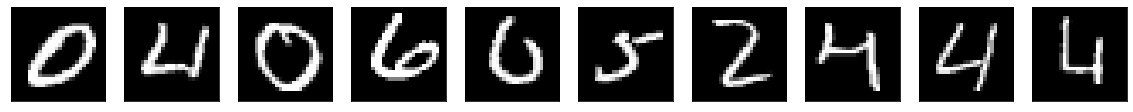

In [15]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_contaminated[np.argsort(err)[::-1]][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.title('$x_'+str(i)+'$')
plt.show()

In [16]:
# create outlier labels
# normal:  0
# outlier: 1
y_true = np.copy( y_contaminated )
y_true[y_contaminated == 4] = 0
y_true[y_contaminated != 4] = 1 # set outliers as 1

# Perform max-min normalization on the errors
n_err = np.copy( err )
n_err = n_err / np.max(n_err)

AUC = roc_auc_score(y_true, n_err)
print(AUC)

0.7218533604887983
